# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></div><div class="lev1 toc-item"><a href="#Data" data-toc-modified-id="Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data</a></div><div class="lev1 toc-item"><a href="#Recession-extraction" data-toc-modified-id="Recession-extraction-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Recession extraction</a></div><div class="lev2 toc-item"><a href="#Vogel-&amp;-Kroll" data-toc-modified-id="Vogel-&amp;-Kroll-31"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Vogel &amp; Kroll</a></div><div class="lev2 toc-item"><a href="#Brutsaert" data-toc-modified-id="Brutsaert-32"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Brutsaert</a></div><div class="lev2 toc-item"><a href="#Kirchner" data-toc-modified-id="Kirchner-33"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Kirchner</a></div><div class="lev1 toc-item"><a href="#Recession-analysis" data-toc-modified-id="Recession-analysis-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Recession analysis</a></div><div class="lev2 toc-item"><a href="#Linear-regression-(Vogel-and-Kroll)" data-toc-modified-id="Linear-regression-(Vogel-and-Kroll)-41"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Linear regression (Vogel and Kroll)</a></div><div class="lev2 toc-item"><a href="#Lower-envelop-(Brutsaert)" data-toc-modified-id="Lower-envelop-(Brutsaert)-42"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Lower envelop (Brutsaert)</a></div><div class="lev2 toc-item"><a href="#Binning-(Kirchner)" data-toc-modified-id="Binning-(Kirchner)-43"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Binning (Kirchner)</a></div><div class="lev1 toc-item"><a href="#Method-comparison" data-toc-modified-id="Method-comparison-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Method comparison</a></div><div class="lev1 toc-item"><a href="#References" data-toc-modified-id="References-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>References</a></div>

# Introduction

- @author: Damien Delforge
- @email: damien.delforge@uclouvain.be

In the absence of precipitation, periods of recession of a streamflow are generally considered to be representative of the storage-discharge relationship of a watershed. In particular, if the surface storage (lakes, glaciers, ...)  is negligible and under homogeneous hydrogeological conditions, most of the flow comes from the underground water resources and the analysis of the recession periods is supposed to reflect the storage-discharge relationship of the aquifer. As a result, the analysis of recession periods is an open door to the study of the dynamic (and possibly physical properties) of the aquifer. Usually, recession analysis are preformed on daily data. 

However, recession analysis methods (RAM) have to deal with technical challenges to both extract recession events and analyze them. In terms of extraction, it is generally observed that after peak flows due to direct runoff, the early recession remains under the influence of other components before being exclusively driven by the aquifer discharge. For this reason, RAMs often discard this early period with respect to some heuristic rules. Regarding the investigation of the recovered recession segments, the analysis is usually model-based in the sense that assumptions about the dynamics of the recession are made. In most case, it consists in considering the aquifer as linear or nonlinear reservoirs with no other abstraction than discharge. The following model is used to consider both linear and nonlinear storage-outflow relationship, considering a daily streamflow time series, $Q = Q(t)$:

$$
-\frac{dQ}{dt} = aQ^b
$$

where $a$ and $b$ are constants ($b = 1$ in the case of a linear reservoir). By the means of a log-log plot, one may estimates both constants using linear regression as:

$$
log(-\frac{dQ}{dt}) = b*log(Q) + log(a)
$$

where $b$ is the slope of the line and $log(a)$ the intercept. Such a log-log representation of the recession points is called a **recession plot**.

This notebook introduces three different RAMs (Vogel and Kroll, 1992; Brutsaert, 2008; Kirchner James W., 2009) based on the one compared in Stoelzle et al., 2013. All three consists in three different recession extraction procedures and 3 different regression techniques applied on the recession plot. The later paper also questions whether the recession characteristics are truly characteristics since different RAMs may yield to different outcomes. As always in hydrology, the use of simple and recognized but highly reductionist concepts (eg. return period, time of concentration, ...) can be questioned. The choice is up to the expert based on his knowledge of how, where, when and for what purpose a tool works and on his ability of selecting the best tool  or combination of tools for a given task.

In [190]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.measurements import label
import statsmodels.api as sm
%matplotlib inline

# Data


,Discharge [cms]
count,7306.000000
mean,4.288430
std,4.649659
min,0.150000
25%,1.237397
50%,2.812920
75%,5.607426
max,62.117227


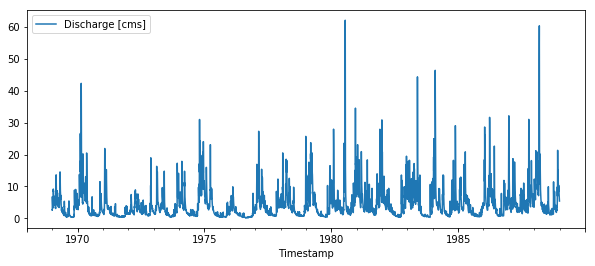

In [2]:
# Loading and resampling to daily mean discharge
q = pd.read_csv('data/discharge.csv', 
                parse_dates=True, 
                index_col=0).resample('D').mean()
q.plot(figsize=(10,4))
q.describe()

# Recession extraction

Note that in Stoezle et al. the original streamflow data is pre-whitened with $Q = (Q_t + Q_{t-1})/2$. This whitening is suggested in Brusaert and Nieber. For comparison constistency, it is previously applied before all methods.

## Vogel & Kroll

Vogel and Kroll (1996) suggested to extract recession events from the decreasing parts of 3-day moving averages of streamflow. These segments must have a minimum length of 10 continuous days, and the decline in discharge for two consecutive data values has to be smaller than 30 %. Furthermore the first 30 % of every recession segment is excluded to avoid the influence of storm and surface runoff at the beginning of streamflow recessions.

Applying the rolling mean can be easily done with pandas python library. We define recession event as negative slope. The percentage of decline is computed. Recession events are then individually labeled using the scipy label function. We then need to iterate through the labeled recession events to extract the beginning, the end and the duration.

In [3]:
# Pre-whitening

q['Discharge [cms]'] = (q['Discharge [cms]'] + q['Discharge [cms]'].shift(-1))/2
q = q.iloc[:-1]

# Applying 3 days moving average
q['MA3'] = q['Discharge [cms]'].rolling(window=3).mean()
# Define coarse recession event
q['is_recession'] = np.logical_and(q['MA3'].diff() < 0, 
                                   q['Discharge [cms]'].diff() < 0)
# Compute the decline ratio
q['decline_pct'] = abs(q['Discharge [cms]'].diff()) / q['Discharge [cms]']
# Label each recession event using scipy label
evt, nlab = label(q['is_recession'])
q['evt'] = evt
# Creation of a event dataframe
evtdf1 = pd.DataFrame(columns=['start', 'rstart', 'end', 'duration', 'valid'])
for e in range(1,nlab+1):
    sel = q[q['evt'] == e]
    evtdf1.loc[e, 'start'] = sel.index[0] 
    evtdf1.loc[e, 'end'] = sel.index[-1]
    duration = sel.index[-1] - sel.index[0]
    evtdf1.loc[e, 'duration'] = duration
    evtdf1.loc[e, 'rstart'] = sel.index[0] + duration.days // 3
    evtdf1.loc[e, 'valid'] = all(sel['decline_pct'] < 0.3)
evtdf1 = evtdf1[evtdf1['valid']]
evtdf1 = evtdf1[evtdf1['duration']>= pd.to_timedelta('10 Days')]
evtdf1.reset_index(inplace=True, drop=True)
print('Number of recession events: {}'.format(len(evtdf1)))
evtdf1.head()

Number of recession events: 83


,start,rstart,end,duration,valid
0,1969-02-27 00:00:00,1969-03-02 00:00:00,1969-03-10 00:00:00,11 days 00:00:00,True
1,1969-03-16 00:00:00,1969-03-20 00:00:00,1969-03-29 00:00:00,13 days 00:00:00,True
2,1969-12-27 00:00:00,1969-12-31 00:00:00,1970-01-08 00:00:00,12 days 00:00:00,True
3,1970-05-14 00:00:00,1970-05-22 00:00:00,1970-06-07 00:00:00,24 days 00:00:00,True
4,1970-12-06 00:00:00,1970-12-14 00:00:00,1971-01-01 00:00:00,26 days 00:00:00,True


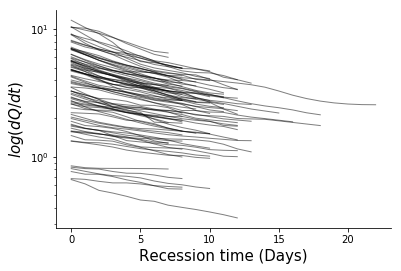

In [4]:
fig = plt.figure()
ax = fig.gca()
for i, e in evtdf1.iterrows():
    sel = q.loc[e['rstart']:e['end']]
    ax.semilogy(sel['Discharge [cms]'].values, color='k', lw=1., alpha=0.5)
ax.set_ylabel('$log(dQ/dt)$', fontsize=15)
ax.set_xlabel('Recession time (Days)', fontsize=15)
for side in ['right','top']:
    ax.spines[side].set_visible(False)

## Brutsaert

The Brutsaert method (Brutsaert, 2008) extracts recession parts from hydrograph with the following criteria: no values with positive or zero dQ/dt are allowed and three data points after the last and two data points before the first positive or zero dQ/dt are eliminated. Additionally a fourth data point is excluded after major events. Due to no further specification, Stoelzle _et al_ defined in their study a major event as streamflow values greater than the 30 % exceedance frequency (Q30) during the period of record.Further on, the Brutsaert method eliminates data points followed by values with a larger −dQ/dt in order to exclude sudden anomalies and the ups and downs of dQ/dt values during a recession.

This methods requires to evaluate the Q30 value. To do so, we will rely on the percentile 70 of the data and on the _flow duration curve_ (FDC) that pictures the percentage of time a streamflow discharged is equaled or exceeded.

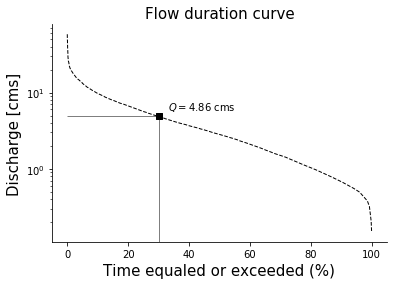

In [5]:
q = pd.read_csv('data/discharge.csv', 
                parse_dates=True, 
                index_col=0).resample('D').mean()

q['Discharge [cms]'] = (q['Discharge [cms]'] + q['Discharge [cms]'].shift(-1))/2
q = q.iloc[:-1]

qt = q['Discharge [cms]']

partition = np.linspace(max(qt), min(qt), 1000)
pctge = np.zeros(len(partition))

for i, qp in enumerate(partition):
    pctge[i] = np.sum(np.greater_equal(qt,qp))/len(qt)*100
    
q30 = np.percentile(qt, 70)

fig = plt.figure()
ax = fig.gca()
ax.set_title('Flow duration curve', fontsize=15)
ax.semilogy(pctge, partition, '--k', lw=1)
ax.scatter(30, q30, marker='s', color='k')
ax.text(33, q30 + 1, '$Q = {:.2f}$ cms'.format(q30))
ax.vlines(30, 0, q30, lw=0.5)
ax.hlines(q30, xmin = 0, xmax= 30, lw=0.5)
ax.set_xlabel('Time equaled or exceeded (%)', fontsize=15)
ax.set_ylabel('Discharge [cms]', fontsize=15)
#ax.grid(which='minor', lw=0.5, ls=':')
for side in ['right','top']:
    ax.spines[side].set_visible(False)

In [6]:
q['is_recession'] = q['Discharge [cms]'].diff() < 0
# Computing Q30
q30 = np.percentile(q['Discharge [cms]'], 70)
# Label each recession event using scipy label
evt, nlab = label(q['is_recession'])
q['evt'] = evt
evtdf2 = pd.DataFrame(columns=['start', 'rstart', 'end','rend', 'duration', 'valid'])
evtdf2['valid'] = False
for e in range(1,nlab+1):
    sel = q[q['evt'] == e]
    sel2 = q[q['evt'] == e -1]
    stormevt = q.loc[sel2.index[-1]:sel.index[0]]
    is_major = any(stormevt>q30)
    evtdf2.loc[e, 'start'] = sel.index[0] 
    evtdf2.loc[e, 'end'] = sel.index[-1]
    duration = sel.index[-1] - sel.index[0]
    evtdf2.loc[e, 'duration'] = duration
    evtdf2.loc[e, 'rstart'] = sel.index[0] + 3 + int(is_major)
    evtdf2.loc[e, 'rend'] = sel.index[-1] -2
evtdf2['valid'] = evtdf2['rend']  > evtdf2['rstart']
evtdf2 = evtdf2[evtdf2['valid']]
evtdf2.reset_index(inplace=True, drop=True)
print('Number of recession events: {}'.format(len(evtdf2)))
evtdf2.head()

Number of recession events: 203


,start,rstart,end,rend,duration,valid
0,1969-01-04 00:00:00,1969-01-08 00:00:00,1969-01-11 00:00:00,1969-01-09 00:00:00,7 days 00:00:00,True
1,1969-01-19 00:00:00,1969-01-23 00:00:00,1969-01-27 00:00:00,1969-01-25 00:00:00,8 days 00:00:00,True
2,1969-02-03 00:00:00,1969-02-07 00:00:00,1969-02-10 00:00:00,1969-02-08 00:00:00,7 days 00:00:00,True
3,1969-02-26 00:00:00,1969-03-02 00:00:00,1969-03-10 00:00:00,1969-03-08 00:00:00,12 days 00:00:00,True
4,1969-03-14 00:00:00,1969-03-18 00:00:00,1969-03-29 00:00:00,1969-03-27 00:00:00,15 days 00:00:00,True


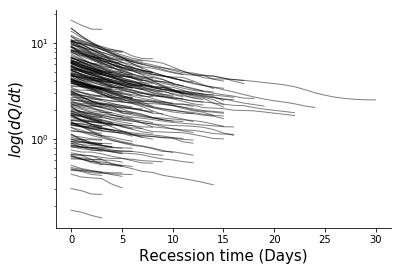

In [7]:
fig = plt.figure()
ax = fig.gca()
for i, e in evtdf2.iterrows():
    sel = q.loc[e['rstart']:e['end']]
    ax.semilogy(sel['Discharge [cms]'].values, color='k', lw=1., alpha=0.5)
ax.set_ylabel('$log(dQ/dt)$', fontsize=15)
ax.set_xlabel('Recession time (Days)', fontsize=15)
for side in ['right','top']:
    ax.spines[side].set_visible(False)

Remember that later on, the  Brusaert method do not allows -dQ/dt values larger than one at the beginning of recession. These will be filtered out for the recession plot.

## Kirchner

The Kirchner method keeps all positive $-dQ/dt$ points for the regression analysis. 

In [8]:
q = pd.read_csv('data/discharge.csv', 
                parse_dates=True, 
                index_col=0).resample('D').mean()

q['Discharge [cms]'] = (q['Discharge [cms]'] + q['Discharge [cms]'].shift(-1))/2
q = q.iloc[:-1]

q['is_recession'] = q['Discharge [cms]'].diff() < 0

# Label each recession event using scipy label
evt, nlab = label(q['is_recession'])
q['evt'] = evt
evtdf3 = pd.DataFrame(columns=['start', 'end', 'duration'])
for e in range(1,nlab+1):
    sel = q[q['evt'] == e]
    evtdf3.loc[e, 'start'] = sel.index[0] 
    evtdf3.loc[e, 'end'] = sel.index[-1]
    duration = sel.index[-1] - sel.index[0]
    evtdf3.loc[e, 'duration'] = duration
print('Number of recession events: {}'.format(len(evtdf3)))
evtdf3.head()

Number of recession events: 899


,start,end,duration
1,1969-01-04 00:00:00,1969-01-11 00:00:00,7 days 00:00:00
2,1969-01-17 00:00:00,1969-01-17 00:00:00,0 days 00:00:00
3,1969-01-19 00:00:00,1969-01-27 00:00:00,8 days 00:00:00
4,1969-01-30 00:00:00,1969-01-31 00:00:00,1 days 00:00:00
5,1969-02-03 00:00:00,1969-02-10 00:00:00,7 days 00:00:00


# Recession analysis

We first harmonized our database of recession events into one single dataframe to prepare for the recession plot.

In [9]:
q = pd.read_csv('data/discharge.csv', 
                parse_dates=True, 
                index_col=0).resample('D').mean()

q['Discharge [cms]'] = (q['Discharge [cms]'] + q['Discharge [cms]'].shift(-1))/2
q = q.iloc[:-1]
q.columns=['Q']
q['-dQdt'] =  -q['Q'].diff()

# VOG method
q['is_recess_vog'] = False
for i, e in evtdf1.iterrows():
    sel = q.loc[e['rstart']:e['end']]
    q.loc[sel.index[0]:sel.index[-1], 'is_recess_vog'] = True

# Brutsaert
q['is_recess_bru'] = False
for i, e in evtdf2.iterrows():
    sel = q.loc[e['rstart']:e['rend']]
    dQdt0 = sel['-dQdt'][0]
    q.loc[sel.index[0]:sel.index[-1], 'is_recess_bru'] = True
    # Exclusion of points with larger - dQ/dt
    q.loc[sel[sel['-dQdt'] > dQdt0].index, 'is_recess_bru'] = False
    
# Kirchner
q['is_recess_kir'] = False
for i, e in evtdf3.iterrows():
    sel = q.loc[e['start']:e['end']]
    q.loc[sel.index[0]:sel.index[-1], 'is_recess_kir'] = True

q = q.iloc[1:]


## Linear regression (Vogel and Kroll)

Vogel and Kroll use an ordinary least square (OLS) regression on the recession plot. We will use statsmodel for the linear regression.

In [10]:
from sklearn import linear_model

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1373c0566d8>)

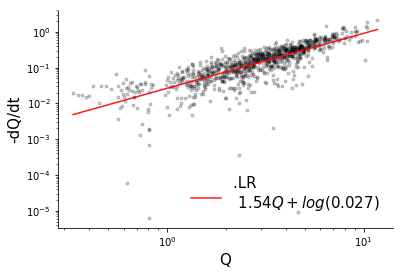

In [255]:
recess = q[q['is_recess_vog']]

def vog_recessplot(q, dqdt, ax=None, lab=''):
    # Create linear regression object
    regr = linear_model.LinearRegression()
    x_train = np.log10(q).values.reshape(-1, 1)
    y_train = np.log10(dqdt).values.reshape(-1, 1)
    # Train the model using the training sets
    regr.fit(x_train, y_train)
    if not ax:
        fig = plt.figure()
        ax = fig.gca()
    else:
        fig = ax.get_figure()
    ax.loglog(10**x_train, 10**y_train, '.', color='k', alpha=0.2)
    x = np.linspace(min(q),max(q))
    y = regr.predict(np.log10(x.reshape(-1,1)))
    b = regr.coef_[0][0]
    a = regr.intercept_[0]
    ax.loglog(x, np.power(10,y), 'r-', alpha=0.9, label='{}.LR \n ${:.3}Q + log({:.2})$'.format(lab, b, 10**a))
    for side in ['right','top']:
        ax.spines[side].set_visible(False)
    ax.legend(frameon=False, fontsize=15)
    ax.set_xlabel('Q', fontsize=15)
    ax.set_ylabel('-dQ/dt', fontsize=15)
    return fig, ax

vog_recessplot(recess['Q'], recess['-dQdt'])
    

## Lower envelop (Brutsaert)

>The Brutsaert method suggests
a lower envelope to parameterize the recession model
with 5 % of the points below it, to take unavoidable errors
into account. As the literature lacks the specific implementation
details, in this study the model was fitted by means of
a quantile regression (Koenker and Bassett Jr., 1978).

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x137405cb048>)

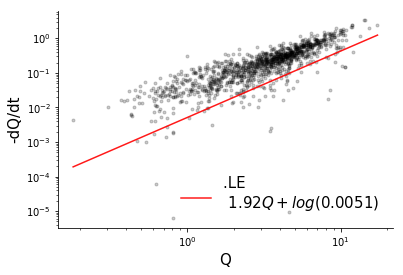

In [256]:
## Quantile regression for the median, 0.5th quantile 
 
import statsmodels.formula.api as smf

def bru_recessplot(q, dqdt, ax=None, lab=''):
    # Create quantile regression object
    
    data = pd.DataFrame()
    data['x'] = np.log10(q)
    data['y'] = np.log10(dqdt)
    mod = smf.quantreg('y ~ x', data) 
    res = mod.fit(q=.05) 
    a, b = res.params['Intercept'], res.params['x']
    
    if not ax:
        fig = plt.figure()
        ax = fig.gca()
    else: 
        fig = ax.get_figure()
    ax.loglog(10**data['x'], 10**data['y'], '.', color='k', alpha=0.2, label='')
    x = np.linspace(min(q),max(q))
    y = a + b * np.log10(x)
    ax.loglog(x, np.power(10,y), 'r-', alpha=0.9, label='{}.LE \n ${:.3}Q + log({:.2})$'.format(lab, b, 10**a))
    for side in ['right','top']:
        ax.spines[side].set_visible(False)
    ax.legend(frameon=False, fontsize=15)
    ax.set_xlabel('Q', fontsize=15)
    ax.set_ylabel('-dQ/dt', fontsize=15)
    return fig, ax

recess = q[q['is_recess_bru']]
bru_recessplot(recess['Q'], recess['-dQdt'])

## Binning (Kirchner)

> The Kirchner method fits a
least squares regression through the binned means, weighted
by the square of the standard error of each binned average
(Kirchner, 2009). Due to the fact that this weighting is based
on the previously calculated standard error of the binned
means, we followed Krakauer and Temimi (2011), who have
suggested a minimum data points’ quantity in each bin. In
order to calculate weights for each bin in each catchment,
we have to define a minimum amount of binned data points
(n = 6). Figure 1 illustrates an example of the applied RAMs
and the different recession plots.

Following Krakauer and Temini
> The selected values of Q˙ (i.e. those when the lagged precipitation
and snowmelt were small, and excluding periods
of rising streamflow) were then averaged over ranges of Q.
These ranges were selected as follows (cf. Kirchner, 2009):
(1) begin with the top 1 % of the logarithmic range in Q; (2)
compute the mean and standard error of Q˙ for all Q in that
range; (3) if the number of values in the range is less than
9 or the mean Q˙ is nonnegative or the standard error in Q˙
is more than half its absolute mean value, expand the bin by
another 1 % of the logarithmic range; (4) otherwise, keep the
mean Q and Q˙ of the bin and continue with the next 1 % of
the logarithmic range. This resulted in typically 20–70 bins
(median 58 bins), each with a mean Q, mean Q˙ , and standard
error of Q˙ . Regression on the binned values is basically
equivalent to weighted regression on the original hourly data,
where weighting is by the inverse variance of Q˙ over a small
range in Q.

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1373a1157f0>)

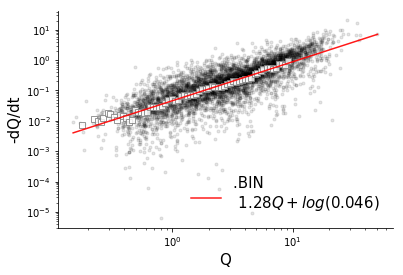

In [258]:
def kir_recessplot(q, dqdt, ax=None, lab=''):
    logq = pd.DataFrame()
    logq['Q'] = np.log10(q.values)
    logq['-dQdt'] = np.log10(dqdt.values)
    logdq = np.log10(dqdt)
    qrng = np.linspace(logq['Q'].min(), logq['Q'].max(), 100)
    k = 0
    stats = pd.DataFrame(columns=['Q_mean', '-dQdt_mean', 'se', 'count'])
    
    # Binning values
    for i, _ in enumerate(qrng):
        if i < 99:
            rmin = qrng[k]
            rmax = qrng[i+1]
            stat = logq[(logq['Q'] > rmin) & (logq['Q'] < rmax)].describe()
            mq = stat.loc['mean', 'Q']
            mdq = stat.loc['mean', '-dQdt']
            n = stat.loc['count', 'Q']
            se = stat.loc['std', '-dQdt']/np.sqrt(n)
            con1 = n >= 6
            con2 = mdq < 0
            con3 = se < np.abs(m)
            valid = all([con1, con2, con3])

            if not valid:
                continue
            else:
                stats.loc[i] = [mq, mdq, se, n]
                k = i
    
    # Weighted regression
    
    Y = stats['-dQdt_mean'].values
    X = stats['Q_mean'].values
    W = (1./stats['se']**2).values
    X = sm.add_constant(X)
    wls_model = sm.WLS(Y,X, weights=W)
    results = wls_model.fit()
    a, b = results.params
    x = np.linspace(q.min(),q.max())
    y = a + b * np.log10(x)
    
    # Recession plot
    
    if not ax:
        fig = plt.figure()
        ax = fig.gca()
    else:
        fig = ax.get_figure()
    ax.loglog(q, dqdt, '.', color='k', alpha=0.1, label='')
    ax.loglog(10**stats['Q_mean'], 10**stats['-dQdt_mean'],'s', markerfacecolor='white', markeredgecolor='gray', alpha=0.8, label='')
    ax.loglog(x, np.power(10,y), 'r-', alpha=0.9, label='{}.BIN \n ${:.3}Q + log({:.2})$'.format(lab, b, 10**a))
    ax.legend(frameon=False, fontsize=15)
    for side in ['right','top']:
        ax.spines[side].set_visible(False)
    ax.set_xlabel('Q', fontsize=15)
    ax.set_ylabel('-dQ/dt', fontsize=15)
    return fig, ax

recess = q[q['is_recess_kir']]
kir_recessplot(recess['Q'], recess['-dQdt'])

# Method comparison

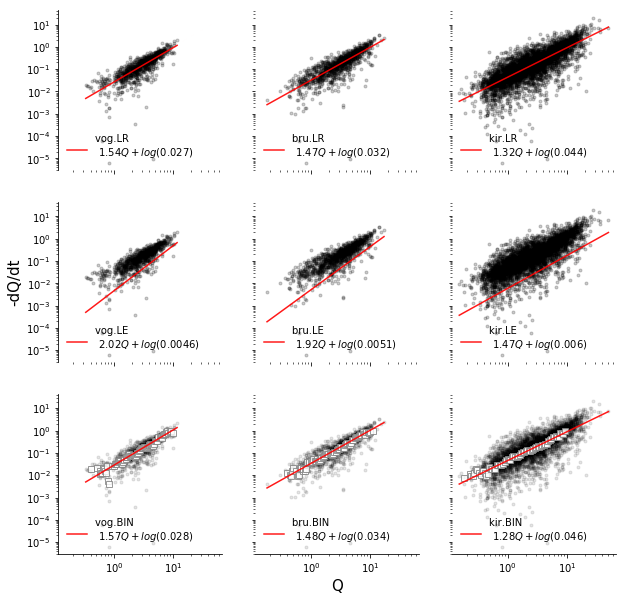

In [259]:
from itertools import product
fig, axes = plt.subplots(3,3, sharex=True, sharey=True, figsize=(10,10))
rplots = [vog_recessplot, bru_recessplot, kir_recessplot]
revts = ['is_recess_vog', 'is_recess_bru', 'is_recess_kir']
methods = list(product(rplots, revts))
axes1d = axes.ravel()
for i, (rplt, revt) in enumerate(methods):
    ax = axes1d[i]
    recess = q[q[revt]]
    _, ax = rplt(recess['Q'], recess['-dQdt'], ax=ax, lab=revt[-3:])
    if i not in [0,3,6]:
        for side in ['left']:
            ax.spines[side].set_visible(False)
    if i not in [6,7,8]:
        for side in ['bottom']:
            ax.spines[side].set_visible(False)
    if i not in [3]:
        ax.set_ylabel('')
    if i not in [7]:
        ax.set_xlabel('')
    
    ax.legend(frameon = False, fontsize=10)

Using 3 recession extraction methods combined with 3 recession regression analysis techniques, we obtained a range of recession parameters. The nonlinearity parameter $b$ varies between 1.28 (Kirchner extraction with binning regression) and 2.02 (Vogel extraction with lower envelop regression). 

# References

* Brutsaert, W. and Nieber, J. L.: Regionalized drought flow hydrographs from a mature glaciated plateau, Water Resources Research, 13(3), 637–643, doi:10.1029/WR013i003p00637, 1977.

* Brutsaert, W.: Long-term groundwater storage trends estimated from streamflow records: Climatic perspective: LONG-TERM GROUNDWATER STORAGE TRENDS, Water Resources Research, 44(2), doi:10.1029/2007WR006518, 2008.

* Kirchner, J. W.: Catchments as simple dynamical systems: Catchment characterization, rainfall‐runoff modeling, and doing hydrology backward, Water Resources Research, 45(2), doi:10.1029/2008WR006912, 2009.

* Krakauer, N. Y. and Temimi, M.: Stream recession curves and storage variability in small watersheds, Hydrol. Earth Syst. Sci., 15(7), 2377–2389, doi:10.5194/hess-15-2377-2011, 2011.

* Stoelzle, M., Stahl, K. and Weiler, M.: Are streamflow recession characteristics really characteristic?, Hydrol. Earth Syst. Sci., 17(2), 817–828, doi:10.5194/hess-17-817-2013, 2013.

* Vogel, R. M. and Kroll, C. N.: Regional geohydrologic-geomorphic relationships for the estimation of low-flow statistics, Water Resources Research, 28(9), 2451–2458, doi:10.1029/92WR01007, 1992.
